In [1]:
# ## Table of Contents
# 1. [Dataset Loading and Initial Exploration]
# 2. [Data Quality Assessment]
# 3. [Basic Duplicate Detection Methods]
# 4. [Advanced Duplicate Analysis]
# 5. [Risk Scoring Framework]
# 6. [Temporal Pattern Analysis]
# 7. [Business Rule Implementation]
# 8. [Visualization and Reporting]
# 9. [Recommendations and Conclusions]

# Dataset Loading and Initial Exploration

In [2]:
# Load the transaction dataset and perform a basic inspection.
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load dataset
df = pd.read_csv("/kaggle/input/paysim1/PS_20174392719_1491204439457_log.csv")
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


# Data Quality Assessment

In [4]:
# Check data types, missing values, and summary statistics.
df.info()
print("\nMissing values per column:")
print(df.isnull().sum())
df.describe(include='all')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB

Missing values per column:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6362620,6.362620e+06,6362620,6.362620e+06,6.362620e+06,6362620,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
unique,NaN,5,NaN,6353307,NaN,NaN,2722362,NaN,NaN,NaN,NaN
top,NaN,CASH_OUT,NaN,C1902386530,NaN,NaN,C1286084959,NaN,NaN,NaN,NaN
freq,NaN,2237500,NaN,3,NaN,NaN,113,NaN,NaN,NaN,NaN
mean,2.433972e+02,NaN,1.798619e+05,NaN,8.338831e+05,8.551137e+05,NaN,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,NaN,6.038582e+05,NaN,2.888243e+06,2.924049e+06,NaN,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,NaN,0.000000e+00,NaN,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,NaN,1.338957e+04,NaN,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,NaN,7.487194e+04,NaN,1.420800e+04,0.000000e+00,NaN,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,NaN,2.087215e+05,NaN,1.073152e+05,1.442584e+05,NaN,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00


# Basic Duplicate Detection Methods

In [5]:
# Search for exact and field-based duplicates.
# Check for exact duplicate rows
exact_duplicates = df[df.duplicated(keep=False)]
print(f"Exact duplicates found: {exact_duplicates.shape[0]}")

Exact duplicates found: 0


In [6]:
# Check for duplicates using key transaction features
if {'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'amount'}.issubset(df.columns):
    field_dupes = df[df.duplicated(['nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'amount'], keep=False)]
    print(f"Key field duplicates found: {field_dupes.shape[0]}")
else:
    print("Some expected fields for duplicate analysis are not in the dataset.")


Key field duplicates found: 0


# Advanced Duplicate Analysis

In [7]:
# Detect near duplicates or pattern-based anomalies.
from difflib import SequenceMatcher

def similarity(a, b):
    return SequenceMatcher(None, a, b).ratio()

sample_names = df['nameOrig'].dropna().sample(10).tolist()
for i in range(len(sample_names)):
    for j in range(i + 1, len(sample_names)):
        sim_score = similarity(sample_names[i], sample_names[j])
        if sim_score > 0.85:
            print(f"Similar accounts: {sample_names[i]} ~ {sample_names[j]} | Score: {sim_score:.2f}")


# Risk Scoring Framework

In [8]:
# Assign scores based on amount, transaction type, and time indicators.
def assign_risk(row):
    score = 0
    if row['amount'] > 50000:
        score += 2
    if row['type'] in ['TRANSFER', 'CASH_OUT']:
        score += 1
    return score

df['risk_score'] = df.apply(assign_risk, axis=1)
df[['type', 'amount', 'risk_score']].head()

,type,amount,risk_score
0,PAYMENT,9839.64,0
1,PAYMENT,1864.28,0
2,TRANSFER,181.00,1
3,CASH_OUT,181.00,1
4,PAYMENT,11668.14,0


# Temporal Pattern Analysis

In [9]:
# Analyze time-based patterns to detect rapid repeated transactions.
if 'step' in df.columns:
    df.sort_values(by=['nameOrig', 'step'], inplace=True)
    df['time_diff'] = df.groupby('nameOrig')['step'].diff()
    df[['nameOrig', 'step', 'time_diff']].head()
else:
    print("Time-based field 'step' not found in dataset.")

# Business Rule Implementation

In [10]:
# Implement simple rules to flag high-risk transactions.
def flag_fraud(row):
    if row['risk_score'] >= 2 and (pd.notnull(row.get('time_diff')) and row['time_diff'] <= 1):
        return True
    return False

df['flagged_fraud'] = df.apply(flag_fraud, axis=1)
df[df['flagged_fraud'] == True].head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,risk_score,time_diff,flagged_fraud
2922149,229,TRANSFER,796351.80,C1044884182,906.00,0.00,C1728129856,0.00,796351.80,0,0,3,0.0,True
2146378,184,CASH_IN,200641.71,C1045313014,9378360.15,9579001.86,C960236924,843974.66,643332.95,0,0,2,1.0,True
5856588,402,TRANSFER,654191.15,C1061931265,15095.00,0.00,C420576773,0.00,654191.15,0,0,3,0.0,True
4012955,299,TRANSFER,1234398.59,C1068240459,54909.00,0.00,C2051037280,710999.97,1945398.56,0,0,3,1.0,True
394692,18,CASH_IN,98843.20,C111557025,11525943.54,11624786.74,C1656503620,4990293.84,4891450.64,0,0,2,1.0,True


# Visualization and Reporting

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


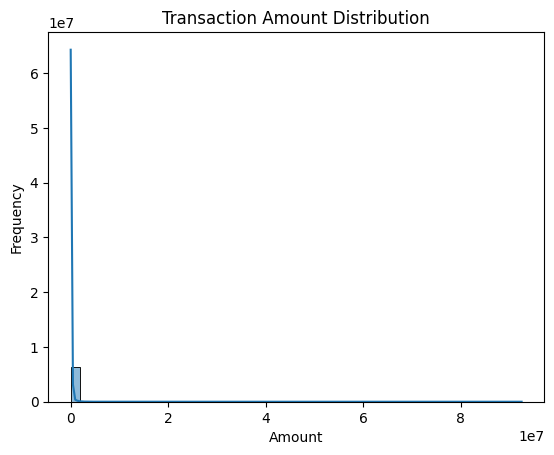

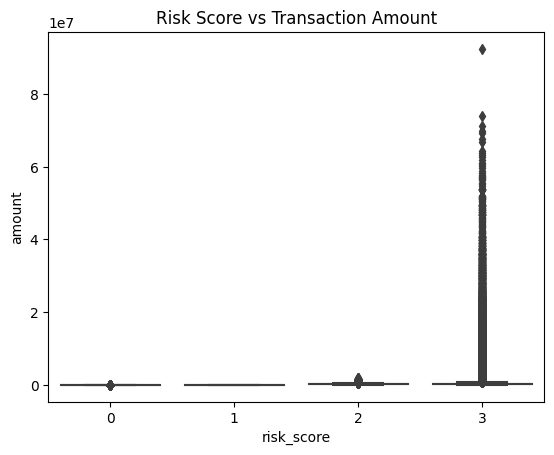

In [11]:
# Visualize transaction patterns and outliers.
sns.histplot(df['amount'], bins=50, kde=True)
plt.title("Transaction Amount Distribution")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.show()

#
sns.boxplot(x='risk_score', y='amount', data=df)
plt.title("Risk Score vs Transaction Amount")
plt.show()

# Recommendations and Conclusions

In [12]:
# Suggestions for enhancing fraud detection processes.
print(f"Total transactions flagged as potential fraud: {df['flagged_fraud'].sum()}")
print("\nRecommendations:")
print("- Monitor high-value and high-frequency transactions.")
print("- Investigate accounts with suspicious similarity or behavior.")
print("- Implement thresholds and machine learning for automated flagging.")

Total transactions flagged as potential fraud: 64

Recommendations:
- Monitor high-value and high-frequency transactions.
- Investigate accounts with suspicious similarity or behavior.
- Implement thresholds and machine learning for automated flagging.
